General declarations, including used libraries, support and plotting function.
Python version 2.7+ must be installed along with the following packages:
numpy, pandas, gensim(topic modeling), nltk (Natural Language Processing Toolkit), codecs, sklearn (statistical learning package), mpld3, MySQLdb, pylab, csv, string, matplotlib (plotting), wordcloud (only if word clouds plotting is desired), seaborn (plotting), pickle (to save clusters and other data objects).

In [33]:
import os
import numpy as np
import pandas as pd
import nltk
import codecs
from sklearn import feature_extraction
import mpld3
import MySQLdb
import pandas.io.sql as sql
import pandas as pd
import numpy as np
from pylab import *
import pylab as py
import csv
import string
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.externals import joblib
from sklearn import metrics
from __future__ import print_function
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import seaborn as sns
import pickle

sns.set(style="white", color_codes=True)

import warnings
warnings.filterwarnings("ignore")

# Show plots in-line
%matplotlib inline

# Stopword list.
# List of words that will be filtered out of the building permit text, includes words that 
# are removed in google searches (pronouns, transition words, etc),  prepositions and some names, as well, etc. 
stopwords=set(unicode("contractor put system message request done get several bid mail text name discuss today needs buildzoom brother jessica give like send estimate regards additional httpwww im youre chat details regarding new help provide know messaging home also needing speaking searching also information hi available email call please project interested contact looking project need job phone work hire james hbcode thomas david michael robert subtype richard permit building none america rochester william needs brother jessica give like send estimate im youre chat details regarding hi available email call please interested contact looking project need job phone work so some somebody somehow someone something sometime sometimes somewhat somewhere soon sorry specified specify specifying still sub such sup sure t's take taken tell tends th than thank thanks thanx that that's thats the their theirs them themselves then thence there there's thereafter thereby therefore therein theres thereupon these they they'd they'll they're they've think third this thorough thoroughly those though three through throughout thru thus to together too took toward towards tried tries truly try trying twice two un under unfortunately unless unlikely until unto up upon us use used useful uses using usually value various very via viz vs want wants was wasn't way we we'd we'll we're we've welcome well went were weren't what what's whatever when whence whenever where where's whereafter whereas whereby wherein whereupon wherever whether which while whither who who's whoever whole whom whose why will willing wish with within without won't wonder would wouldn't yes yet you you'd you'll you're you've your yours yourself yourselves zero a about above after again against all am an and any are aren't as at be because been before being below between both but by can can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on one once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves").split())

# Declare controlled vocabulary (i.e. lexicon)
r=open('./Data/Controlled_Lex.tsv','r')
Lexicon=r.readlines()
Lexicon=set(Lexicon[0].split('\r'))

Tokenization, text filtering and pre-processing functions

In [46]:
# Read Data from BuildZoom service requests
def read_c(input_file):
    with open(input_file, 'rU') as f:
        reader = csv.reader(f,delimiter='\t')
        for row in reader:
            text=row
    return text

# Function to construct a word cloud plot.
# Input: list of words associated to a text document, name for the wordcloud file to be outputted 
def plot_wordcloud(text,name):
    top_join=map(join_txt,text)
    all_text=' '.join(top_join)
    
    wordcloud = WordCloud(font_path='/Library/Fonts/Arial.ttf').generate(all_text)
    # Open a plot of the generated image.
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(name+'.png') # save as png
    plt.show()

# Build AIC curve for a given dictionary corpus and an array that specifies the number
# of topics you want to explore
# In this case, the number of chunks and passes are fixed and intended to be "smaller" numbers
def Build_AIC(text,n_topics):
    # Apply filter, build corpus and dictionaries
    # Use the raw text, apply filter and build frequency array
    d_text=[content2tokens(s) for s in text]
    frequency=B_Freq(d_text)
    # Remove words that appear only once
    d_text = [[token for token in text if frequency[token] > 1]
        for text in d_text]
    # Build dictionary and corpus
    dictionary = corpora.Dictionary(d_text)
    corpus = [dictionary.doc2bow(text) for text in d_text]
    # Start running different iterations of the LDA model and saving their AIC and log bounds
    AIC=[]
    Bound=[]
    # Run LDA for different number of topics and save AIC values and log-bound. 
    for i in n_topics:
        lda = gensim.models.ldamulticore.LdaModel(corpus=corpus,id2word=dictionary,
                                                  chunksize=1000,num_topics=i,passes=2)
        l=lda.bound(corpus)
        Bound.append(l)
        AIC.append(2*((i*len(dictionary))-l))
    plt.plot(n_topics, Bound)
    plt.xlabel('Number of topics')
    plt.ylabel('Value')
    plt.title('Log Bound')
    return [AIC,Bound]
    
# Function to join text for a given list. 
# Inputs: list with strings
def join_txt(x):
    content = ' '.join(filter(None,x))
    return content

# Text pre-processing function.
# Filter out spaces, punctuation, unnecessary whitespaces. 
# Any stop-word is also removed
# Additionally, this function also removes any word smaller than 4 characters
# Inputs: list with string for each building permit
def content2tokens(s):
    # Turn all letters to lower-case
    content = s.lower()
    # remove periods
    content = content.replace('.', ' ')  
    # Split words
    content = ' '.join(content.split())
    # Remove punctuation
    for c in content:
        if c in string.punctuation or c.isdigit():
            content=content.replace(c," ")
    
    # Split string into a list
    content = content.split()
    # Filter words from the stoplist 
    content = filter(lambda w: w not in stopwords, content)
    # Filter words smaller than 2 characters
    content = filter(lambda w: len(w) > 2, content)
    return content

# Text pre-processing function, that also applies the Snowball stemmer to each word
# This function's only difference compared to content2tokens is the use of the stemmer. 
# Filter out spaces, punctuation, unnecessary whitespaces. 
# Any stop-word is also removed
# Additionally, this function also removes any word smaller than 4 characters
# Inputs: list with string for each building permit
def content2stems(s):
    # Initialize Snowball stemmer
    stemmer = SnowballStemmer("english")
    # Transform all letters to lower-case
    content = s.lower()
    # Remove periods
    content = content.replace('.', ' ')    
    # Split words
    content = ' '.join(content.split())
    # Remove punctuation
    for c in content:
        if c in string.punctuation or c.isdigit():
            content=content.replace(c," ")
    
    # Split words into a list
    content = content.split() 
    # Filter words from the stoplist
    content = filter(lambda w: w not in stopwords, content)  
    # Filter words smaller than 2 characters
    content = filter(lambda w: len(w) > 2, content)
    # Apply Snowball stemmer to words
    content = [stemmer.stem(t) for t in content]    
    return content

# Build frequency array with words (for use with LDA model)
def B_Freq(d_text):
    from collections import defaultdict
    frequency = defaultdict(int)
    for text in d_text:
        for token in text:
            frequency[token] += 1    
    return frequency

# Prints out LDA topics in a more organized fashion
def print_topics(lda):
    # Print out words
    for i in range(lda.num_topics):
        words = [str(w) for _,w in lda.show_topic(i)]
        print (words)

def sym_kl(p,q):
    return np.sum([stats.entropy(p,q),stats.entropy(q,p)])

# Function to compute Arun-metric to analyze LDA model
def arun(corpus,dictionary,max_topics,min_topics=1,step=1):
    l = np.array([sum(cnt for _, cnt in doc) for doc in corpus])
    kl = []
    for i in range(min_topics,max_topics,step):
        lda = models.ldamodel.LdaModel(corpus=corpus,
            id2word=dictionary,num_topics=i)
        m1 = lda.expElogbeta
        U,cm1,V = np.linalg.svd(m1)
        #Document-topic matrix
        lda_topics = lda[my_corpus]
        m2 = matutils.corpus2dense(lda_topics, lda.num_topics).transpose()
        cm2 = l.dot(m2)
        cm2 = cm2 + 0.0001
        cm2norm = np.linalg.norm(l)
        cm2 = cm2/cm2norm
        kl.append(sym_kl(cm1,cm2))
    return kl

# Pre-processing Pipeline require prior to trying to fit the LDA model. 
def Preprocess_Pipeline(text):
    # Use the raw text, apply filter and build frequency array
    d_text=[content2tokens(s) for s in text]
    frequency=B_Freq(d_text)
    # Filter out documents that might become empty (probably trash that I to take another look at and remove)
    d_text = filter(None,d_text)
    # Remove words that appear only once
    d_text = [[token for token in text if frequency[token] > 1]
        for text in d_text]
    # Build dictionary and corpus
    dictionary = corpora.Dictionary(d_text)
    corpus = [dictionary.doc2bow(text) for text in d_text]
    
    return (d_text,corpus,dictionary)

# Function to print out clusters and their top associated words
# Inputs: k-mean fitted objected (outputted from nltk), vocabulary frame and number of cluster used.
# Output: This function prints out the top words associated to each cluster and also saves the
# cluster number+word pair and returns it (dict_pairs)
def KM_Cluster_Print(km,vocab_frame,num_clusters):
    # Obtain cluster from K-M object
    clusters = km.labels_.tolist()
    
    # Build pairs for dictionary
    dict_pairs=[]
    # The following is to print out the clusters
    print("Top terms per cluster:")
    print()
    # Sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    
    # Print out individual worlds for each cluster
    for i in range(num_clusters):
        words=''
        print("Cluster %d words:" % i, end='')
        for ind in order_centroids[i, :8]: #replace with n words per cluster that you want to view
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
            # Build string with top words associated to the cluster
            words=words+vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]+', '
        print() #add whitespace
        print() #add whitespace
        # Save cluster number + top word pairs
        dict_pairs.append((i,words))
    print()
    print()
    
    return dict_pairs

# Function to print out clusters and their top associated words to a csv file
# Inputs: k-mean fitted objected (outputted from nltk), vocabulary frame and number of cluster used.
# Output: This function prints out the top words associated to each cluster and also saves the
# cluster number+word pair and returns it (dict_pairs) and writes it out to a csv file. 
def KM_Cluster_PrintFile(km,vocab_frame,num_clusters):
    # Obtain cluster from K-M object
    clusters = km.labels_.tolist()
    
    # Build pairs for dictionary
    dict_pairs=[]
    
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    
    # Print out individual worlds for each cluster
    for i in range(num_clusters):
        words=''
        for ind in order_centroids[i, :5]: #replace with n words per cluster
            # Build string with top words associated to the cluster
            words=words+vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]+', '
        # Save pair of cluster number + top words associated to that cluster
        dict_pairs.append((i,words))
    
    # Write out dict_pairs object list into csv file
    with open('./Clusters/'+str(num_clusters)+'_Service_ClusterWords.csv', 'wb') as f:
        writer = csv.writer(f)
        writer.writerows(dict_pairs)
    
    return dict_pairs  

# Toolbar used for cluster figure
# Define custom toolbar location for the html object that shows cluster proximities
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

# *** Function that does multi-dimensional scaling (using t-distributed stochastic neighbor embedding) ***
# We convert the space to two components as we're plotting points in a two-dimensional plane
def Cluster_Visualize(dist_centers,file_name):
    # We will also specify `random_state` so the plot is reproducible.
    tsne = TSNE(n_components=2, random_state=1)

    pos = tsne.fit_transform(dist_centers)  # shape (n_components, n_samples)

    xs, ys = pos[:, 0], pos[:, 1]

    # Set up colors per clusters using a dict
    cm = py.get_cmap('gist_rainbow')
    cluster_colors = (cm(1.*i/num_clusters) for i in range(num_clusters))
    cluster_names = dict(cluster_pairs)

    # Create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=range(0,num_clusters), title=range(0,num_clusters))) 
        
    # Group by cluster
    groups = df.groupby('label')

    # Define custom css to format the font and to remove the axis labeling
    css = """
    text.mpld3-text, div.mpld3-tooltip {
      font-family:Arial, Helvetica, sans-serif;
    }

    g.mpld3-xaxis, g.mpld3-yaxis {
    display: none; }

    svg.mpld3-figure {
    margin-left: -200px;}
    """

    # Plot 
    fig, ax = plt.subplots(figsize=(14,6)) #set plot size
    ax.margins(0.15) # Optional, just adds 5% padding to the autoscaling

    # Iterate through groups to layer the plot
    # Note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
    
        ax.set_color_cycle(cluster_colors)
        points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, mec='none')
        ax.set_aspect('auto')
        labels = [str(i)+' '+cluster_names[i] for i in group.title]
    
        #set tooltip using points, labels and the already defined 'css'
        tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
        #connect tooltip to fig
        mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
        #set tick marks as blank
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
    
        #set axis as blank
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    
    ax.legend(numpoints=1) #show legend with only one dot

    mpld3.display() #show the plot

    # Uncomment the below to export to html
    mpld3.save_html(fig,file_name)

Run the code below is we are pulling the data directly from BuildZoom

In [27]:
# Host, username, password, database to connect
host='db.dev.buildzoom.com'
username='new'
passwr='bzdb123zoom'
db='bzdb'
# Fetch a subset of the service request data with status >= 1
f = open('s_request_query.txt', 'r')
query=f.read()
# Open database connection
connect = MySQLdb.connect(host,username,passwr,db)
s_requests = sql.read_sql(query, connect)
# Concatenate the service request text
requests_text=s_requests.title+' '+s_requests.description
requests_text=map(lambda x: unicode(x,errors='ignore'),requests_text)
# Save file with the service requests
file_name='S_Requests.tsv'
out = csv.writer(open(file_name,"w"), delimiter='\t',quoting=csv.QUOTE_ALL)
out.writerow(requests_text)

If we are reading the requests_text from file, instead.

In [35]:
file_name='S_Requests.tsv'
requests_text=read_c('./Data/S_Requests.tsv')
requests_text=map(lambda x : unicode(x, errors='ignore'),requests_text)

Use pre-processing functions and apply Latent Dirichlet Allocation (LDA) to client's service request texts.

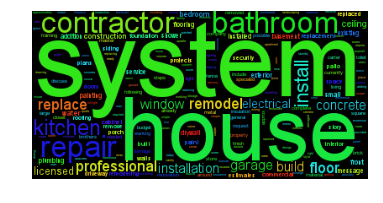

['discuss', 'garage', 'windows', 'doors', 'roofing', 'contractor', 'electrical', 'plumbing', 'drywall', 'construction']
['install', 'front', 'concrete', 'porch', 'patio', 'installation', 'replace', 'steps', 'driveway', 'fence']
['painting', 'exterior', 'paint', 'contractors', 'interior', 'commercial', 'residential', 'painted', 'wooden', 'projects']
['kitchen', 'bathroom', 'remodel', 'repair', 'floor', 'install', 'replace', 'shower', 'ceiling', 'remodeling']
['house', 'today', 'addition', 'build', 'garage', 'contractor', 'construction', 'property', 'story', 'space']


In [16]:
# Build dictionary and corpus for all subsets of the data
requests_filtered,corpus,dictionary=Preprocess_Pipeline(requests_text)
# Build wordcloud based on most frequent words
plot_wordcloud(requests_filtered,'all')
# Run LDA to the service request corpus data
lda_all = gensim.models.ldamulticore.LdaModel(corpus=corpus,id2word=dictionary,num_topics=5,
                                              chunksize=500,passes=2)
print_topics(lda_all)

K-Means clustering analysis using the service requests text

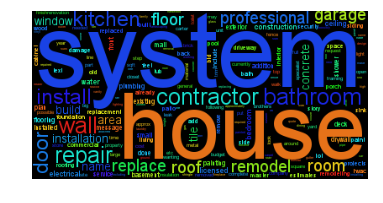

In [48]:
# Pre-process and filter words
# Use the raw text, apply filters and tokenize. 
# We save two versions of the tokenization, original and stemmed. The reason for this is to later be able to compare
# the original word that was replaced for its stem (just for reference).
service_text=[content2tokens(s) for s in requests_text]
service_stems=[content2stems(s) for s in requests_text]
# These objects simply save the whole vocabulary, also to use for refence later on. 
totalvocab_tokenized=[]
totalvocab_stem=[]
# Build extended vocabulary
for i in service_text:
    totalvocab_tokenized.extend(i)
for i in service_stems:
    totalvocab_stem.extend(i)

# Build wordcloud based on most frequent words
plot_wordcloud(service_text,'./Plots/service_requests')

# Build pandas dataframe with vocabulary
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stem)

# Use NLTK's tf_idf vectorizer
# Define vectorizer parameters
# The vectorization will only be done on words that appear less than a fraction of the frequency given by 
# max_df, appear more times that that given by min_df, were not filtered in stop_words. 
# The function content2stems, defined previously, does the tokenization.
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200,
                                 min_df=70, stop_words=stopwords,
                                 use_idf=True, tokenizer=content2stems, 
                                 decode_error='ignore',ngram_range=[1,1])

tfidf_matrix = tfidf_vectorizer.fit_transform(requests_text) # Fit the vectorizer to build_permits
terms = tfidf_vectorizer.get_feature_names() # Save the terms that remain from the vectorization

# Save vocabulary and terms
with open('./Clusters/service_terms.pickle', 'w') as f:
    pickle.dump([tfidf_matrix,terms,vocab_frame], f)
    
# Getting back the objects, if you want to use them from a previously saved file.
#with open('service_terms.pickle') as f:
#    tfidf_matrix, terms, vocab_frame = pickle.load(f)

# Get distance matrix from tfidf matrix using cosine similarity between each document
# This calculation can be computationally intensive, and should be performed and used if another clustering approach,
# such as hierarchical clustering, is intend. 
# dist = 1 - cosine_similarity(tfidf_matrix)

## **** Number of clusters to run the K-Means algorithm **** ###
num_clusters = 300

# Clustering using the default Euclidian distance
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

# Save clusters to an object file
joblib.dump(km,'./Clusters/service_clusters_'+str(num_clusters)+'.pkl')
    
# Read saved model and look at clusters
# km = joblib.load('service_clusters.pkl')

# Print out clusters and most representative words
# cluster_pairs=KM_Cluster_Print(km,vocab_frame,num_clusters)
cluster_pairs=KM_Cluster_PrintFile(km,vocab_frame,num_clusters)

# Get cluster centers
cluster_centers = km.cluster_centers_
# Get distance matrix between each document. In this case, we use the cosine similarity as the metric. 
dist_centers = 1 - cosine_similarity(cluster_centers)

Cluster_Visualize(dist_centers,'./Clusters/Fig_Service_'+str(num_clusters)+'.html')

*** Work in progress ***

Read previously constructed clusters from building permits and predict the type of service requests based on those. 

In [27]:
# If running with a pre-run vocabulary, use the following tfidf_vectorizer call instead. 
# tfidf_vectorizer = TfidfVectorizer(vocabulary=terms, stop_words=stopwords,
#                                   use_idf=True, tokenizer=content2stems, 
#                                   decode_error='ignore',ngram_range=[1,1])